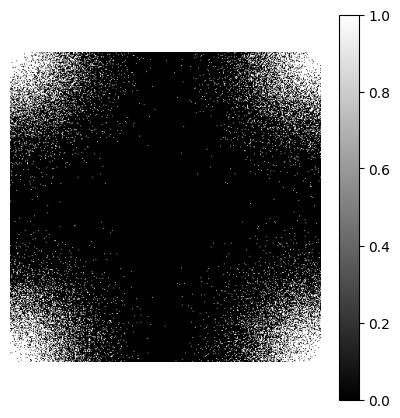

Iter 0: Loss = 110.2517
Iter 0: Gradient = 8.8466
data_term = 43.92910017446249
tv_term = 66.32263764610173
Iter 50: Loss = 53.9493
Iter 50: Gradient = 1.1377
data_term = 18.180124638620768
tv_term = 35.769156666182226
Iter 100: Loss = 51.0698
Iter 100: Gradient = 0.5293
data_term = 16.81414242915331
tv_term = 34.2556970733544
Iter 150: Loss = 50.1630
Iter 150: Gradient = 0.3393
data_term = 16.231264394392866
tv_term = 33.931711059137115
Iter 200: Loss = 49.7725
Iter 200: Gradient = 0.2288
data_term = 15.949645510179666
tv_term = 33.822819665997216
Iter 250: Loss = 49.5887
Iter 250: Gradient = 0.1596
data_term = 15.808428951002549
tv_term = 33.780248688169024
Iter 300: Loss = 49.4963
Iter 300: Gradient = 0.1159
data_term = 15.732661206417012
tv_term = 33.76367451927498
Iter 350: Loss = 49.4458
Iter 350: Gradient = 0.0875
data_term = 15.688512472262492
tv_term = 33.75729039053465
Iter 400: Loss = 49.4162
Iter 400: Gradient = 0.0673
data_term = 15.660178156997342
tv_term = 33.75603244423

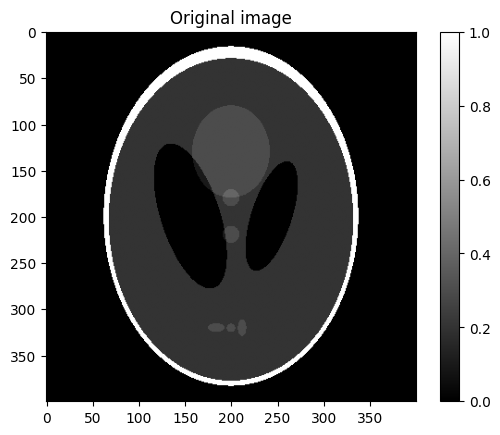

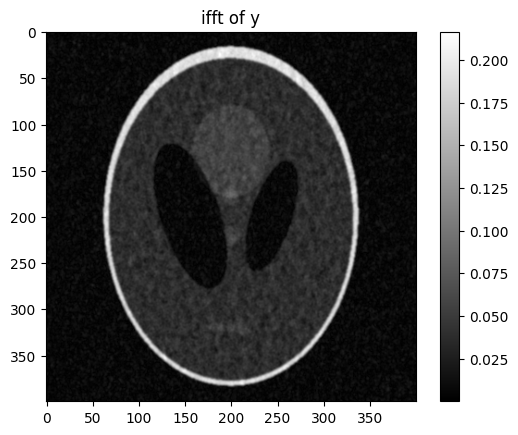

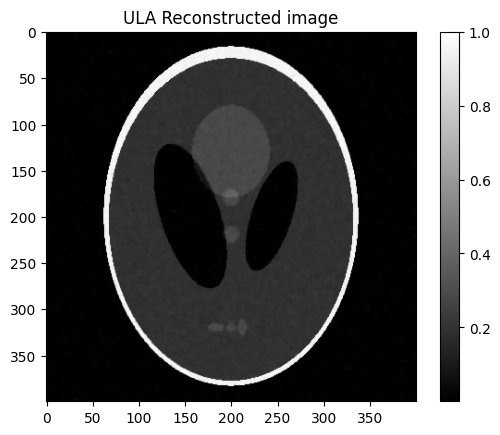

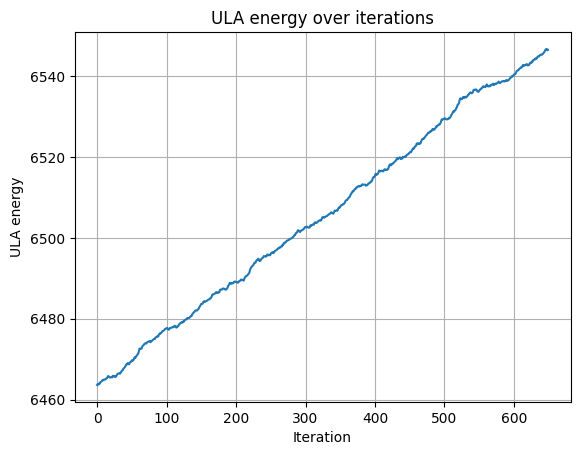

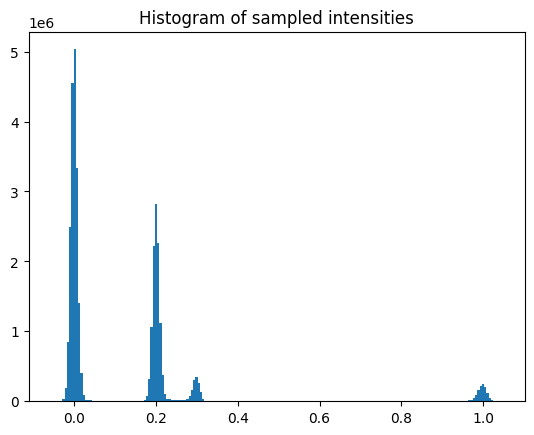

PSNR ULA: 33.13 dB, NMSE ULA: 0.0080, SSIM ULA: 0.8958
PSNR iFFT: 23.61 dB, NMSE iFFT: 0.0715, SSIM iFFT : 0.3091


In [1]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
    RadialMask
)
from utilities.metrics import ssim, nmse, psnr
from MAP.map_tv_minimize import MAPEstimator
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA

# load image
shepp_logan = ski.data.shepp_logan_phantom() # has values [0,1]
# normalize image
# shepp_logan = shepp_logan / np.max(np.abs(shepp_logan))

# create mask (in the F domain)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.5, 0.15, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask('gaussian', 0.2, seed=30).generate(shepp_logan.shape) # default used decay_param=0.3 - 0.5
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, 2, 1, seed=30).get_mask()
radial_mask = RadialMask(shepp_logan.shape, 60, 0.12).generate()

# the 'actual' measurement
vd_mask_shift_corrected = np.fft.fftshift(vd_mask)
sigma_noise = 0.05 # default 0.01
# Generate complex AWGN (MRI noise is complex Gaussian)
noise = (sigma_noise / np.sqrt(2)) * (
   np.random.randn(*shepp_logan.shape) + 1j * np.random.randn(*shepp_logan.shape)
)

# Mask must be applied to noise too — only sampled locations are noisy!!
y = vd_mask_shift_corrected * (np.fft.fft2(shepp_logan, norm='ortho') + noise)
# y_norm = y / np.max(np.abs(y))

####################################################################
# mask
####################################################################

# plot mask
plt.figure(figsize=(5, 5))
plt.imshow(vd_mask_shift_corrected, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.colorbar()
plt.axis('off')
plt.show()

####################################################################
# MAP
####################################################################

# given sigma=0.5 and norm='ortho'; L_data = 1/sigma² = 1/0.0025 = 400
# so: lr < 1/L meaning lr < 1/400 ≈ 2.5e-3 (safe) 

map_estimator = MAPEstimator(vd_mask_shift_corrected, sigma_noise, 0.015, 1e-2, 0.1, 1000) # 0.1, 1e-2, 1e-3, 400

map_reconstruct = map_estimator.subgradient_descent(y)

# # Target
# plt.title("Original image")
# plt.imshow(shepp_logan, cmap="gray")
# plt.colorbar()
# plt.show()  
# # iFFT plot
# plt.title("ifft of y")
# plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
# plt.colorbar()
# plt.show()   
# # MAP plot
# plt.title("MAP Reconstructed image")
# plt.imshow(np.abs(map_reconstruct) / np.abs(map_reconstruct.max()), cmap="gray")
# plt.colorbar()
# plt.show()

# MAP loss
# plt.plot(map_estimator.loss_history)
# plt.title("Loss over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

# MAP gradient
# plt.plot(map_estimator.grad_norm_history)
# plt.title("Gradient norm over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient norm")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()

# psnr_map = psnr(map_reconstruct.real, shepp_logan) # .real because shepp-logan is also real-valued
# nmse_map = nmse(map_reconstruct.real, shepp_logan)
# ssim_map = ssim(map_reconstruct.real, shepp_logan)
# print(f"PSNR MAP: {psnr_map:.2f} dB, NMSE MAP: {nmse_map:.4f}, SSIM MAP: {ssim_map:.4f}")

#####################################################################
# ULA 
#####################################################################
ula_estimator = MMSEEstimatorULA(vd_mask_shift_corrected, sigma_noise, 0.1, 1e-2, 1e-8, 250, 2, 200) 

samples, energies = ula_estimator.ula_sampling(y, x_init=map_reconstruct)
ula_mmse = ula_estimator.compute_mmse_estimate(samples)

# Target
plt.title("Original image")
plt.imshow(shepp_logan, cmap="gray")
plt.colorbar()
plt.show()  
# iFFT plot
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
plt.colorbar()
plt.show()   
# ULA plot
plt.title("ULA Reconstructed image")
plt.imshow(np.abs(ula_mmse) / np.abs(ula_mmse.max()), cmap="gray")
plt.colorbar()
plt.show() 

# ula energy
plt.plot(energies)
plt.title("ULA energy over iterations")
plt.xlabel("Iteration")
plt.ylabel("ULA energy")
plt.grid(True)
#plt.yscale('log')
plt.show()

samples_array = np.array(samples)
plt.hist(samples_array.ravel(), bins=200)
plt.title("Histogram of sampled intensities")
plt.show()

psnr_ula = psnr(ula_mmse.real, shepp_logan) 
nmse_ula = nmse(ula_mmse.real, shepp_logan)
ssim_ula = ssim(ula_mmse.real, shepp_logan)
print(f"PSNR ULA: {psnr_ula:.2f} dB, NMSE ULA: {nmse_ula:.4f}, SSIM ULA: {ssim_ula:.4f}")

#####################################################################
# MALA
#####################################################################
#mala_estimator = MMSEEstimatorMALA(vd_mask_shift_corrected, 0.005, 20*0.1, 1e-2, 1e-4, 350, 2, 200) # used previously (0.005, 20*0.1, 1e-2, 1e-4, 350, 2, 200)

# samples_kept, energies, step_trace, accept_trace = mala_estimator.mala_sampling(y)
# mala_mmse = mala_estimator.compute_mmse_estimate(samples_kept)

# psnr_mala = psnr(mala_mmse.real, shepp_logan) 
# nmse_mala = nmse(mala_mmse.real, shepp_logan)
# ssim_mala = ssim(mala_mmse.real, shepp_logan)
# print(f"PSNR MALA: {psnr_mala:.2f} dB, NMSE MALA: {nmse_mala:.4f}, SSIM MALA: {ssim_mala:.4f}")

# # Target
# plt.title("Original image")
# plt.imshow(shepp_logan, cmap="gray")
# plt.colorbar()
# plt.show()  
# # iFFT plot
# plt.title("ifft of y")
# plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
# plt.colorbar()
# plt.show()   
# # MALA plot
# plt.title("MALA Reconstructed image")
# plt.imshow(np.abs(mala_mmse) / np.abs(mala_mmse.max()), cmap="gray")
# plt.colorbar()
# plt.show() 
#plt.subplot(1, 3, 3)
  
# MALA graphs
# plt.figure(figsize=(14,6))
# plt.subplot(1,3,1)
# plt.plot(energies)
# plt.title('Energy trace')
# plt.xlabel("Iteration")
# plt.ylabel("MALA energy")
# plt.grid(True)
# plt.subplot(1,3,2)
# plt.plot(accept_trace / (np.arange(len(accept_trace))+1))
# plt.title('Cumulative accept rate')
# plt.subplot(1,3,3)
# plt.plot(step_trace)
# plt.title('Step size trace')
# plt.tight_layout()
# plt.show()

psnr_ifft = psnr(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
nmse_ifft = nmse(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
ssim_ifft = ssim(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
print(f"PSNR iFFT: {psnr_ifft:.2f} dB, NMSE iFFT: {nmse_ifft:.4f}, SSIM iFFT : {ssim_ifft:.4f}")


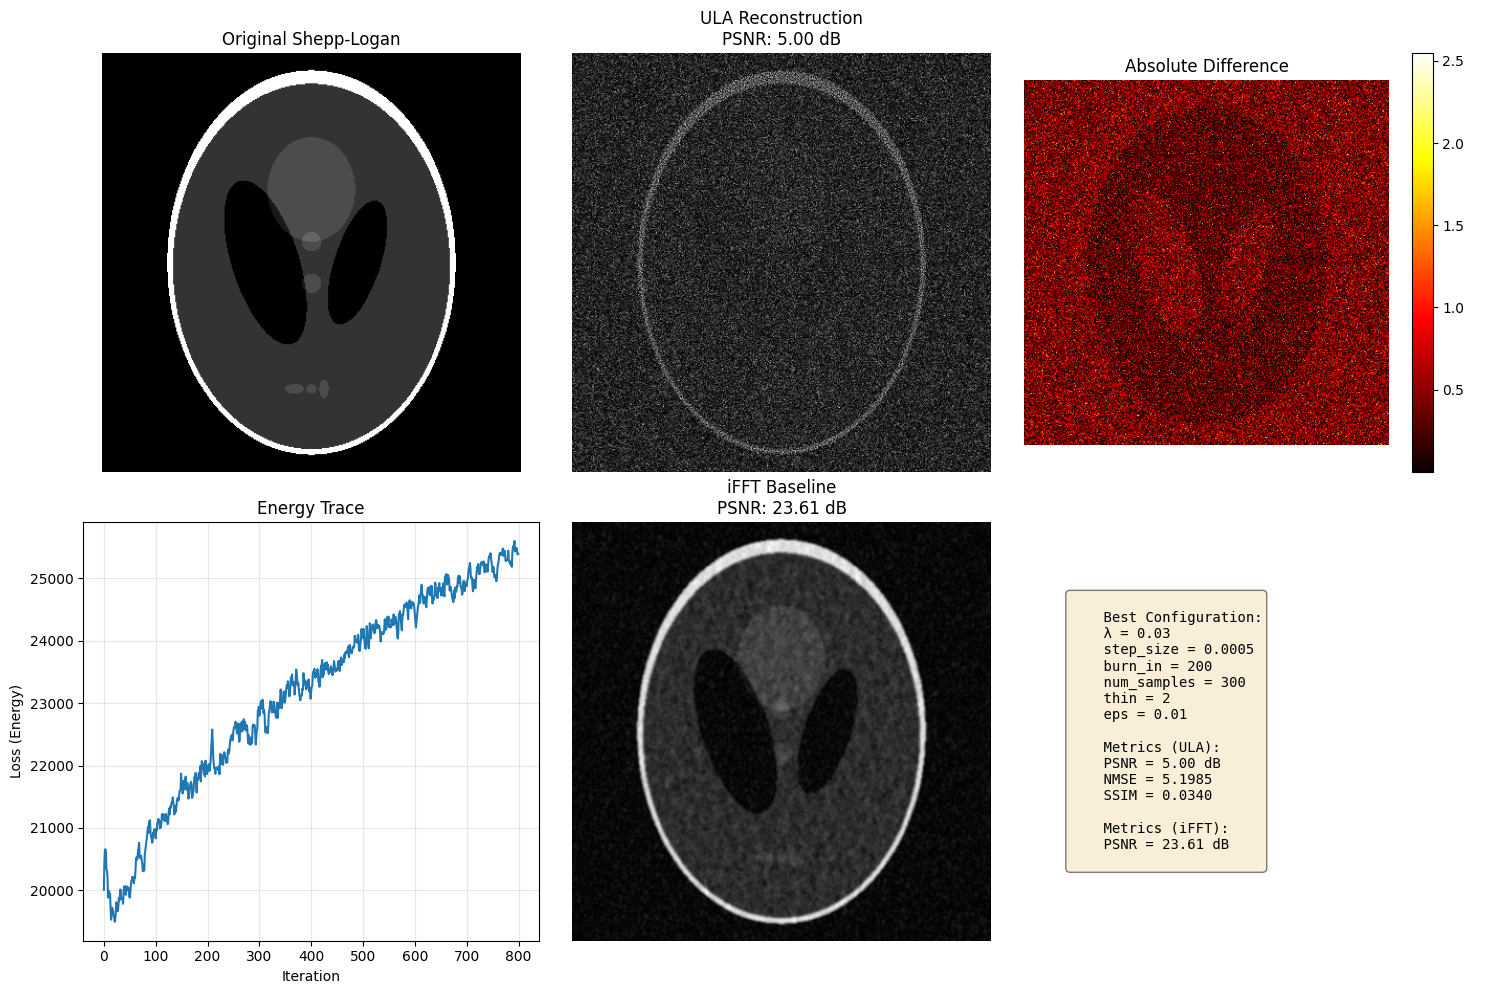

In [ ]:
# Visualize best result
def visualize_best_results(results_list):
    """Visualize original, reconstruction, and difference."""
    if not results_list:
        print("No results yet.")
        return
    
    # Find best by PSNR
    best_idx = max(range(len(results_list)), key=lambda i: results_list[i]['psnr'])
    best_result = results_list[best_idx]
    
    reconstruction = best_result['mmse_estimate']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original
    axes[0, 0].imshow(shepp_logan, cmap='gray')
    axes[0, 0].set_title('Original Shepp-Logan')
    axes[0, 0].axis('off')
    
    # Reconstruction
    axes[0, 1].imshow(np.abs(reconstruction), cmap='gray')
    axes[0, 1].set_title(f"ULA Reconstruction\nPSNR: {best_result['psnr']:.2f} dB")
    axes[0, 1].axis('off')
    
    # Difference
    diff = np.abs(shepp_logan - np.abs(reconstruction))
    im_diff = axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('Absolute Difference')
    axes[0, 2].axis('off')
    plt.colorbar(im_diff, ax=axes[0, 2])
    
    # Energy trace
    axes[1, 0].plot(best_result['energies'])
    axes[1, 0].set_title('Energy Trace')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Loss (Energy)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # iFFT baseline
    ifft_result = np.abs(np.fft.ifft2(y, norm='ortho'))
    axes[1, 1].imshow(ifft_result / ifft_result.max(), cmap='gray')
    ifft_psnr = psnr(ifft_result, shepp_logan)
    axes[1, 1].set_title(f"iFFT Baseline\nPSNR: {ifft_psnr:.2f} dB")
    axes[1, 1].axis('off')
    
    # Metrics comparison
    axes[1, 2].axis('off')
    #results order
    metrics_text = f"""
    Best Configuration:
    λ = {best_result['lambda']}
    step_size = {best_result['step_size']}
    burn_in = {best_result['burn_in']}
    num_samples = {best_result['num_samples']}
    thin = {best_result['thin']}
    eps = {best_result['eps']}
    
    Metrics (ULA):
    PSNR = {best_result['psnr']:.2f} dB
    NMSE = {best_result['nmse']:.4f}
    SSIM = {best_result['ssim']:.4f}
    
    Metrics (iFFT):
    PSNR = {ifft_psnr:.2f} dB
    """
    axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=10, family='monospace',
                    verticalalignment='center', bbox=dict(boxstyle='round', 
                    facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Run after optimization
results = [0.1, 1e-3, 200, 300, 2, 1e-2]

visualize_best_results(results)